# Foot Traffic Data Analysis

In [64]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

Reading in the data

In [65]:
stores = pd.read_csv("data/db/stores.csv", dtype={"store_id":"string"})
customers = pd.read_csv("data/db/customers.csv", dtype={"customer_id":"string"})

visits = pd.read_csv("data/db/visits.csv", dtype={"customer_id":"string", "store_id":"string"})\
    .merge(stores, on="store_id", how="left")\
    .merge(customers, on="customer_id", how="left")

visits["visit_date"] = pd.to_datetime(visits["visit_date"])

display(stores.head())
display(customers.head())
display(visits.head())

,store_id,opened_date,latitude,longitude,store_address,city,state
0,4857,2016-09-12,42.58342,-71.80230,517 Main Street,Fitchburg,Massachusetts
1,2596,2018-10-12,34.06635,-84.67837,2728 North Main Street,Acworth,Georgia
2,7070,2015-12-04,40.63316,-74.13653,8895 Port Richmond Avenue,City of New York,New York
3,6525,2015-12-09,34.21639,-119.03760,269 Ventura Boulevard,Camarillo,California
4,7424,2022-02-02,33.44872,-86.78777,7182 Tyson Drive,Vestavia Hills,Alabama


,customer_id,customer_name,customer_birthday,customer_email,is_member,card_on_file
0,d2a21b4f,Annette Morton,1932-12-01,wmartin@yahoo.com,True,American Express
1,05e6b6f9,Linda Adams,1927-07-18,greenrebecca@miller.com,True,VISA 16 digit
2,ea609017,Eric Wood,1914-09-23,joneswilliam@yahoo.com,True,VISA 19 digit
3,22d03a03,Peter Moore,1998-05-31,ismith@gordon.net,True,Maestro
4,fd08c7b8,Ricky Green,2008-04-08,hollygoodwin@delgado-greer.org,True,JCB 15 digit


,visit_id,visit_date,store_id,customer_id,order_total,payment_method,opened_date,latitude,longitude,store_address,city,state,customer_name,customer_birthday,customer_email,is_member,card_on_file
0,075143e5,2020-01-01,2574,00504361,137.44,cash,2011-04-10,33.44872,-86.78777,7987 Tyson Drive,Vestavia Hills,Alabama,Rachel Carroll,1972-06-19,meganmartin@baker.com,True,JCB 16 digit
1,7795cda5,2020-01-01,2971,8b698701,8.79,credit,2008-08-26,43.91452,-69.96533,5519 Pleasant Street,Brunswick,Maine,Anne Cook,1952-05-11,sweeneycheryl@yahoo.com,False,Diners Club / Carte Blanche
2,a913aabc,2020-01-01,900,4a59e47d,1.72,cash,2000-10-02,40.72816,-74.07764,3760 Olean Avenue,Jersey City,New Jersey,Jasmine English,1953-08-19,jose35@warren-campbell.biz,True,Discover
3,a68e3778,2020-01-01,7070,89d5157a,8.88,credit,2015-12-04,40.63316,-74.13653,8895 Port Richmond Avenue,City of New York,New York,Zachary Hale,1987-06-28,twilcox@reynolds.com,False,JCB 16 digit
4,9be7cdd9,2020-01-01,825,253dd271,453.49,credit,2011-11-22,41.14676,-73.49484,3463 Elm Street,New Canaan,Connecticut,Alyssa Leonard,1984-08-15,patriciasmith@gmail.com,True,VISA 16 digit


## Calculating a time series of total visits by day

In [66]:
visits_by_day = visits.groupby("visit_date").size()\
    .reset_index().rename(columns={0:"visit_count"})

visits_by_day

,visit_date,visit_count
0,2020-01-01,1550
1,2020-01-02,5460
2,2020-01-03,4187
3,2020-01-04,3012
4,2020-01-05,8394
...,...,...
148,2020-05-28,3811
149,2020-05-29,4862
150,2020-05-30,2725
151,2020-05-31,6153


### Resampling for 2-week averages

In [29]:
visits_by_day = visits.groupby("visit_date").size().resample("2W").mean()\
    .reset_index().rename(columns={0:"visit_count"})
visits_by_day

,visit_date,visit_count
0,2020-01-05,3887.800000
1,2020-01-19,3772.142857
2,2020-02-02,3883.428571
3,2020-02-16,5305.214286
4,2020-03-01,5827.428571
5,2020-03-15,5900.214286
6,2020-03-29,5001.142857
7,2020-04-12,4896.714286
8,2020-04-26,4385.714286
9,2020-05-10,5696.642857


### Plotting Time Series

<AxesSubplot: xlabel='visit_date'>

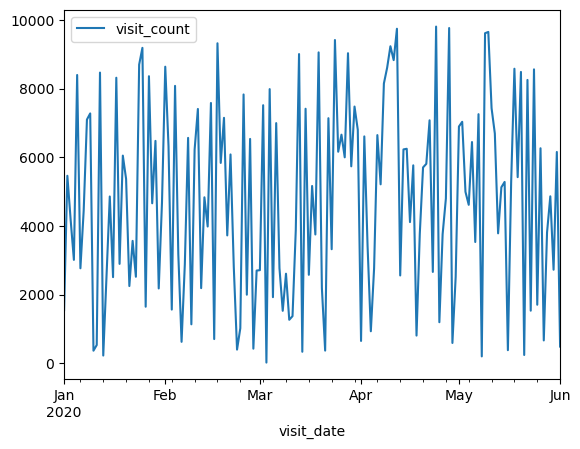

In [68]:
visits_by_day.set_index("visit_date").plot()

## Calculating Gold, Silver, and Bronze Member Tiers

In [73]:
members = visits[visits["is_member"] == True]
member_spend = members.groupby("customer_id").sum()["order_total"].reset_index()
member_spend

C:\Users\kah32\AppData\Local\Temp\ipykernel_11148\138850811.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  member_spend = members.groupby("customer_id").sum()["order_total"].reset_index()


,customer_id,order_total
0,00504361,97303.27
1,0114e945,100528.77
2,01acada6,108935.03
3,027d4869,96142.60
4,028f2dd0,78557.86
...,...,...
728,feabe4c4,89105.96
729,ff3f6120,87090.25
730,ff5ef87b,100045.39
731,ffae3e31,84983.27


In [81]:
member_spend["member_tier"] = pd.qcut(member_spend["order_total"], [0, 0.5, 0.90, 1], labels=["bronze", "silver", "gold"])
display(member_spend.head())
display(member_spend["member_tier"].value_counts())

,customer_id,order_total,member_tier
0,00504361,97303.27,bronze
1,0114e945,100528.77,silver
2,01acada6,108935.03,gold
3,027d4869,96142.60,bronze
4,028f2dd0,78557.86,bronze


bronze    367
silver    292
gold       74
Name: member_tier, dtype: int64

In [82]:
visits = visits.merge(member_spend[["customer_id", "member_tier"]], on="customer_id", how="left")
visits["member_tier"] = visits["member_tier"].astype("string").fillna("Nonmember").astype("category")
visits.head()

,visit_id,visit_date,store_id,customer_id,order_total,payment_method,opened_date,latitude,longitude,store_address,city,state,customer_name,customer_birthday,customer_email,is_member,card_on_file,member_tier
0,075143e5,2020-01-01,2574,00504361,137.44,cash,2011-04-10,33.44872,-86.78777,7987 Tyson Drive,Vestavia Hills,Alabama,Rachel Carroll,1972-06-19,meganmartin@baker.com,True,JCB 16 digit,bronze
1,7795cda5,2020-01-01,2971,8b698701,8.79,credit,2008-08-26,43.91452,-69.96533,5519 Pleasant Street,Brunswick,Maine,Anne Cook,1952-05-11,sweeneycheryl@yahoo.com,False,Diners Club / Carte Blanche,Nonmember
2,a913aabc,2020-01-01,900,4a59e47d,1.72,cash,2000-10-02,40.72816,-74.07764,3760 Olean Avenue,Jersey City,New Jersey,Jasmine English,1953-08-19,jose35@warren-campbell.biz,True,Discover,bronze
3,a68e3778,2020-01-01,7070,89d5157a,8.88,credit,2015-12-04,40.63316,-74.13653,8895 Port Richmond Avenue,City of New York,New York,Zachary Hale,1987-06-28,twilcox@reynolds.com,False,JCB 16 digit,Nonmember
4,9be7cdd9,2020-01-01,825,253dd271,453.49,credit,2011-11-22,41.14676,-73.49484,3463 Elm Street,New Canaan,Connecticut,Alyssa Leonard,1984-08-15,patriciasmith@gmail.com,True,VISA 16 digit,silver


### Visualizing Member Tiers

In [92]:
#pie chart
member_pie = visits["member_tier"].value_counts().reset_index().rename(columns={"index":"member_tier", "member_tier":"count"})
member_pie

,member_tier,count
0,Nonmember,374568
1,bronze,175069
2,silver,144902
3,gold,37710


In [94]:
px.pie(member_pie, names="member_tier", values="count", hole=0.5)

In [99]:
visits[["state", "order_total"]].groupby("state").sum

C:\Users\kah32\AppData\Local\Temp\ipykernel_11148\2813856957.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [9]:
members = visits[visits["is_member"] == True]
mtiers = members.groupby("customer_id").sum()["order_total"].reset_index()
mtiers["membership_tier"] = pd.qcut(mtiers["order_total"], [0,0.5, 0.85, 0.95], labels=["bronze", "silver", "gold"])
df = visits.merge(mtiers[["customer_id", "membership_tier"]], on="customer_id", how="left")
df["membership_tier"] = df["membership_tier"].astype("string").fillna("Nonmember").astype("category")
df.groupby(["visit_date", "membership_tier"]).mean()["order_total"].unstack()#.plot()

C:\Users\kah32\AppData\Local\Temp\ipykernel_119884\379259667.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\kah32\AppData\Local\Temp\ipykernel_119884\379259667.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



membership_tier,Nonmember,bronze,gold,silver
visit_date,,,,
2020-01-01,205.837250,186.856891,212.122134,192.164642
2020-01-02,203.580593,168.280996,229.307736,211.683769
2020-01-03,202.552633,201.204713,210.049017,206.355542
2020-01-04,213.919524,184.765455,241.224444,183.872917
2020-01-05,202.297409,207.387244,228.677261,200.698487
...,...,...,...,...
2020-05-28,199.844967,204.253265,216.415906,210.714187
2020-05-29,198.971923,199.484884,192.078484,218.386806
2020-05-30,204.005329,185.697598,208.455100,204.610649


In [20]:
x = df["membership_tier"].value_counts().reset_index().rename(columns={"index":"membership_tier", "membership_tier":"count"})
px.pie(x, names="membership_tier", values="count", hole=0.4)

In [7]:
x = df["payment_method"].value_counts().to_frame().reset_index()
x.columns = ["payment_method", "count"]
x

px.pie(x, names='payment_method', values='count', hole=0.4)